In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("imagefolder", data_dir="/data_vault/hexai/ArtEmis-FinalSplits/")

label2id = {label: i for i, label in enumerate(dataset["train"].features["label"].names)}
id2label = {i: label for label, i in label2id.items()}

Resolving data files:   0%|          | 0/13311 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1903 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3806 [00:00<?, ?it/s]

In [3]:
from transformers import AutoImageProcessor

checkpoint = "google/efficientnet-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [4]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [5]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [6]:
data_efficient_net = dataset.with_transform(transforms)

In [7]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate precision, recall, and F1-score
        precision = precision_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions, average='macro')
        f1 = f1_score(labels, predictions, average='macro')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

In [9]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([7, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
for param in model.efficientnet.parameters():
    param.requires_grad = False

In [11]:
training_args = TrainingArguments(
    output_dir="artemis_EfficientNet/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-03,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_efficient_net["train"],
    eval_dataset=data_efficient_net["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.844900,1.846596,0.260641,0.216456,0.214046,0.200091
1,1.801100,1.801849,0.283237,0.249557,0.239228,0.231956
2,1.751200,1.770620,0.327903,0.284107,0.282775,0.273265
4,1.743700,1.767591,0.313715,0.268795,0.274951,0.263079
5,1.763500,1.776042,0.306884,0.284150,0.267091,0.263328
6,1.791700,1.762560,0.312139,0.292734,0.272906,0.267237
8,1.749600,1.761215,0.308986,0.416281,0.265123,0.259924
9,1.721800,1.755304,0.318970,0.280662,0.273474,0.268515


/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=340, training_loss=1.7689329599632937, metrics={'train_runtime': 2162.2344, 'train_samples_per_second': 61.561, 'train_steps_per_second': 0.157, 'total_flos': 4.7254047213413376e+17, 'train_loss': 1.7689329599632937, 'epoch': 9.78})

In [12]:
trainer.evaluate(data_efficient_net["test"])

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.770044207572937,
 'eval_accuracy': 0.31056227009984233,
 'eval_precision': 0.2937762493042739,
 'eval_recall': 0.26688403194100246,
 'eval_f1': 0.2597538380125509,
 'eval_runtime': 54.4463,
 'eval_samples_per_second': 69.904,
 'eval_steps_per_second': 0.735,
 'epoch': 9.78}

In [13]:
for param in model.efficientnet.parameters():
    param.requires_grad = True

In [14]:
training_args = TrainingArguments(
    output_dir="artemis_EfficientNet-unfrozen/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-05,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_efficient_net["train"],
    eval_dataset=data_efficient_net["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.718300,1.778345,0.301629,0.305262,0.258046,0.253176
1,1.724100,1.763455,0.305307,0.268398,0.263596,0.256639
2,1.702100,1.746934,0.330531,0.291839,0.288376,0.281507
4,1.696500,1.744139,0.326852,0.284259,0.287209,0.275306
5,1.703400,1.748982,0.310562,0.273310,0.267969,0.263142
6,1.688900,1.733530,0.310037,0.269871,0.271775,0.264128
8,1.673400,1.730251,0.328429,0.427190,0.283227,0.278249
9,1.685800,1.733524,0.333684,0.285170,0.282003,0.274233


/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=340, training_loss=1.7063618435579189, metrics={'train_runtime': 2260.1423, 'train_samples_per_second': 58.895, 'train_steps_per_second': 0.15, 'total_flos': 4.7254047213413376e+17, 'train_loss': 1.7063618435579189, 'epoch': 9.78})

In [15]:
trainer.evaluate(data_efficient_net["test"])

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.72259521484375,
 'eval_accuracy': 0.33920126116657906,
 'eval_precision': 0.3347964073392453,
 'eval_recall': 0.2901453943293283,
 'eval_f1': 0.2847633978472826,
 'eval_runtime': 53.89,
 'eval_samples_per_second': 70.625,
 'eval_steps_per_second': 0.742,
 'epoch': 9.78}

In [16]:
preds, labels = [], []
for batch in data_efficient_net["test"]:
    pix_val = batch["pixel_values"].cuda()
    out = model(pix_val.unsqueeze(dim=0))
    predictions = np.argmax(out.logits.detach().cpu().numpy(), axis=-1)
    preds.extend(predictions)
    labels.append(batch["label"])

In [25]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.33      0.46      0.38       708
           1       0.42      0.48      0.45       680
           2       0.00      0.00      0.00       208
           3       0.33      0.44      0.38       759
           4       0.35      0.26      0.30       454
           5       0.27      0.21      0.24       516
           6       0.39      0.21      0.28       481

    accuracy                           0.35      3806
   macro avg       0.30      0.30      0.29      3806
weighted avg       0.33      0.35      0.33      3806



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, labels):
    """
    Plots the confusion matrix (thanks to Dr. Na-Rae Han).
    """
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()


In [19]:
from sklearn.metrics import confusion_matrix

In [23]:
cm = confusion_matrix(labels, preds)

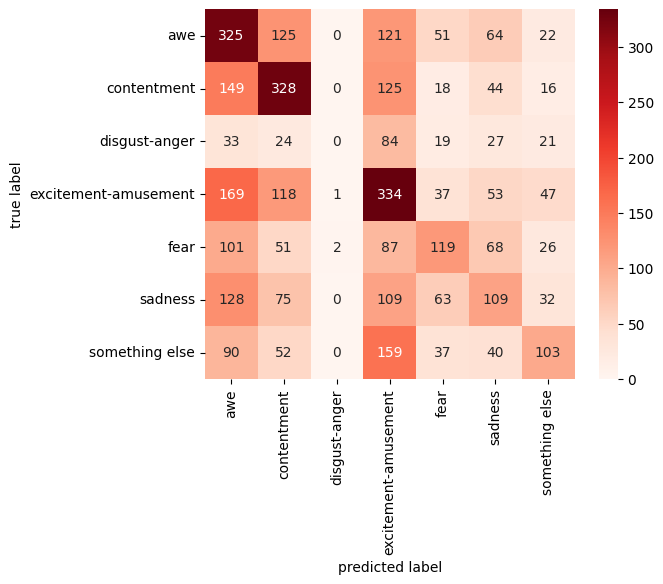

In [24]:
plot_confusion_matrix(cm, id2label.values())

In [ ]:
trainer.save_model("efficientnet_best")

In [1]:
((149+ 33 + 169+101+128+90)/3806  + (125+ 24 + 118+51+75+52)/3806  + (0 + 0 + 1+2+0+0)/3806  + (121+ 125 + 84+87+109+159)/3806 \
+ (51+ 18 + 19+37+63+37)/3806  + (64+ 44 + 27+53+68+40)/3806 + (22+ 16 + 21+47+26+32)/3806 )/7


0.09338638240372345